In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from glob import glob
from const import ID2LABELS_SMG_SHORT as ID2LABELS
import ast
import plotly.express as px

In [2]:
os.environ['OMP_NUM_THREADS']='1'

In [3]:
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
run_name = 'resample_only_single_using_multi'
data_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg\overfit_videomae_vit_base_patch16_224_kinetic_400_densepose_dual\outputs\extracted_features'



In [4]:
# load features
all_file_paths = glob(osp.join(data_folder, '*.npy'))
all_data_list = []
for p in all_file_paths:
    all_data_list.append(np.load(p))
concatenated_array = np.stack(all_data_list, axis=0)

In [5]:
concatenated_array.shape

(4904, 770)

In [6]:
file_ids = [float(osp.basename(f).split('.')[0].split('_ ')[1]) for f in all_file_paths]
file_ids = np.array(file_ids).reshape(-1,1)
concatenated_array = np.concatenate((concatenated_array,file_ids), axis=1)

In [7]:
# Reshape the concatenated array to shape (N/2, d, 2)
even_inds = np.expand_dims(concatenated_array[::2,: ], axis=2)
odd_inds = np.expand_dims(concatenated_array[1::2,: ], axis=2)
reshaped_array = np.concatenate((even_inds, odd_inds), axis=2).mean(axis=2, keepdims=False)

In [8]:
dim_data = 768 # 0 -> target_dim
target_dim = 17 # dim_data + 1 -> target_dim + 1 + target_dim  
index_dim = 1 + 1

In [9]:
ind_start = 0
ind_end = ind_start + dim_data
print(f'{ind_start=}, {ind_end-1=}')

X = reshaped_array[:, ind_start:ind_end]

ind_start = ind_end
ind_end = ind_start + target_dim
print(f'{ind_start=}, {ind_end-1=}')
y_multihot = even_inds[:,ind_start:ind_end].astype(int)

ind_start = ind_end
ind_end = ind_start + index_dim
print(f'{ind_start=}, {ind_end-1=}')
inds = even_inds[:,ind_start:ind_end].astype(int)
# y

ind_start=0, ind_end-1=767
ind_start=768, ind_end-1=784
ind_start=785, ind_end-1=786


In [10]:
print(f'Total shape: {reshaped_array.shape}')
print(f'X shape: {X.shape}')
print(f'y shape: {y_multihot.shape}')
print(f'inds shape: {inds.shape}')
# assert X.shape[1] +  y.shape[1] + inds.shape[1] ==  reshaped_array.shape[1]
print(X.shape[1] +  y_multihot.shape[1] + inds.shape[1])

Total shape: (2452, 771)
X shape: (2452, 768)
y shape: (2452, 3, 1)
inds shape: (2452, 0, 1)
771


In [11]:
from sklearn.preprocessing import LabelEncoder
# Convert multi-hot to single label by concatenating the labels
string_labels = [''.join(map(str, label)) for label in y_multihot]

# Encode the string labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(string_labels)


In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

from umap import UMAP
reducer1 = UMAP(n_components=15,    n_neighbors=15)
reducer2 = UMAP(n_components=2, n_neighbors=5)


# reducer1 = PCA(n_components=15)
# reducer2 = UMAP(n_components=2)

In [13]:
X_reduced = reducer1.fit_transform(X, y=y)
embedding = reducer2.fit_transform(X_reduced, y=y)
# embedding = reducer2.fit_transform(X, y=y)

# X_reduced = reducer1.fit_transform(X)
# embedding = reducer2.fit_transform(X_reduced, y=y)

In [14]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA
# recuder = PCA(n_components=15)
# X_reduced = recuder.fit_transform(X)

In [15]:
from imblearn.under_sampling   import AllKNN, RepeatedEditedNearestNeighbours, EditedNearestNeighbours, NearMiss, TomekLinks,CondensedNearestNeighbour, NeighbourhoodCleaningRule, InstanceHardnessThreshold

from imblearn.combine import SMOTEENN

In [16]:
# resampler = TomekLinks(sampling_strategy='all')
# resampler = NearMiss()
resampler = CondensedNearestNeighbour()
# resampler = NeighbourhoodCleaningRule()
# resampler = InstanceHardnessThreshold()
# resampler =  AllKNN()
# resampler = RepeatedEditedNearestNeighbours()

# resampler = SMOTEENN()

X_rus, y_rus = resampler.fit_resample(X, y)
y_rus.shape

(2452,)

In [17]:
sample_inds = resampler.sample_indices_

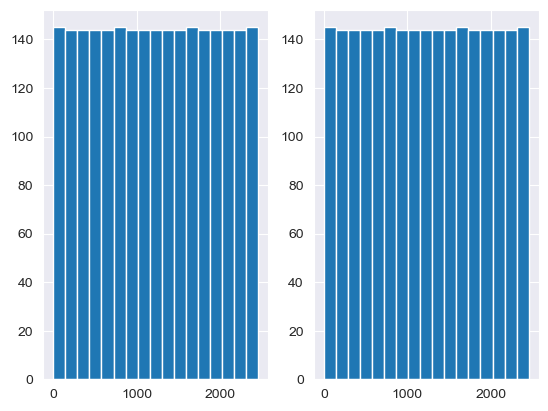

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hist(y_rus, bins=17)
axes[1].hist(y, bins=17)
plt.show()

In [19]:
y_rus

array([   0,    1,    2, ..., 2449, 2450, 2451], dtype=int64)

In [20]:
from collections import Counter
before = np.sum(y_multihot.squeeze(), axis=0)
after = np.sum(y_multihot.squeeze()[sample_inds,:], axis=0)
counts = {'before': before, 'after': after}
df_counters = pd.DataFrame.from_dict(counts)
df_counters.sort_index(inplace=True)
df_counters = df_counters.reset_index()
df_counters['label'] = df_counters['index'].apply(lambda x: ID2LABELS[x+1])
df_counters

,index,before,after,label
0,0,16001,16001,Turtling neck
1,1,3004926,3004926,Rubbing face
2,2,0,0,Folding arms


In [21]:
y_multihot.shape

(2452, 3, 1)

In [165]:
def multihot_to_labels(multi_hot_labels):
    label_inds = np.where(multi_hot_labels == 1)[0]
    ret = [ID2LABELS[x+1] for x in label_inds]
    ret.sort()
    return '+'.join(ret)

# test
# multi_hot_labels = df.loc[df['label'].apply(lambda x: sum(x) > 1)].iloc[2]['label']
# multihot_to_labels(multi_hot_labels)

In [168]:
df = pd.DataFrame(zip(embedding[:,0], embedding[:, 1], y_multihot.squeeze()), columns=['emb1', 'emb2', 'label'])
df['label'] = df['label'].apply(lambda x: multihot_to_labels(x))
df['sample'] = 'all'
df_sub = df.iloc[sample_inds,:].copy()
df_sub['sample'] = 'resample'
df_all = pd.concat([df, df_sub], axis=0)
df_all = df_all.sort_values(by='label')
# sns.relplot(
#     data=df_all, x="emb1", y="emb2",
#     col="sample", hue="label",
#     kind="scatter"
# )

In [172]:
def scatter_plot(df_all):
# Create the scatter plot with Plotly Express
    fig = px.scatter(
        df_all, x='emb1', y='emb2',
        facet_col='sample', color='label',
        title='Scatter plot of emb1 vs emb2 faceted by sample and colored by label'
    )
    
    # Update layout for better spacing between facets
    fig.update_layout(margin=dict(l=20, r=20, t=40, b=20), height=600, width=1600)
    
    
    # Show the plot
    fig.show()
scatter_plot(df_all)

In [115]:
# from collections import Counter
# before = Counter([a[0] for a in y])
# after = Counter([a for a in y_rus])
# counts = {'before': before, 'after': after}
# df_counters = pd.DataFrame.from_dict(counts)
# df_counters.sort_index(inplace=True)
# df_counters = df_counters.reset_index()
# df_counters['label'] = df_counters['index'].apply(lambda x: ID2LABELS[x+1])
# df_counters
# df = pd.DataFrame(zip(embedding[:,0], embedding[:, 1], y_multihot), columns=['emb1', 'emb2', 'label'])
# df['label'] = df['label'].apply(lambda x: ID2LABELS[x[0]+1])
# df['sample'] = 'all'
# df_sub = df.iloc[sample_inds,:].copy()
# df_sub['sample'] = 'resample'
# df_all = pd.concat([df, df_sub], axis=0)
# sns.relplot(
#     data=df_all, x="emb1", y="emb2",
#     col="sample", hue="label",
#     kind="scatter"
# )

KeyError: 25

In [170]:
reducer3 = UMAP(n_components=2 )
embedding_2 = reducer3.fit_transform(X_rus, y_rus)

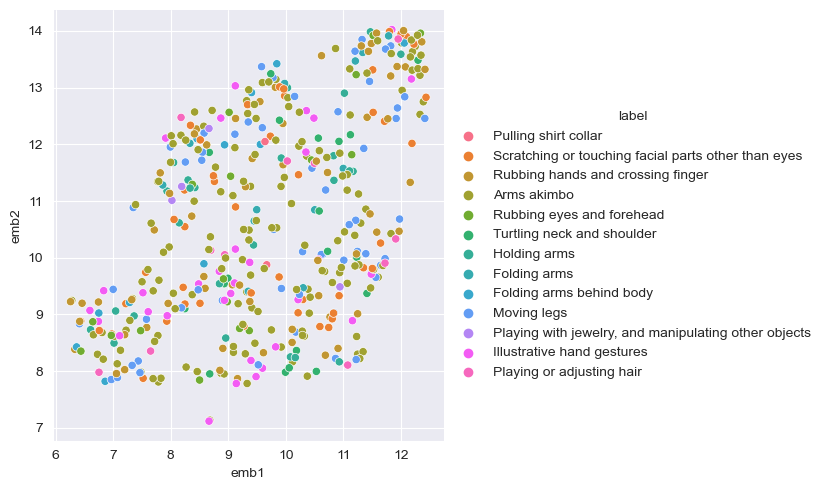

In [22]:
df = pd.DataFrame(zip(embedding_2[:,0], embedding_2[:, 1], y), columns=['emb1', 'emb2', 'label'])
df['label'] = df['label'].apply(lambda x: ID2LABELS[x[0]+1])
df['sample'] = 'all'
# df_sub = df.iloc[sample_inds,:].copy()
# df_sub['sample'] = 'resample'
df_all = pd.concat([df], axis=0)
sns.relplot(
    data=df_all, x="emb1", y="emb2",
    hue="label",
    kind="scatter"
)

In [25]:
# resample train data

train_data_path = osp.join(experiment_folder, run_name,'dataset','train_full.csv')
df_train_orig = pd.read_csv(train_data_path)

In [26]:
df_train_new = df_train_orig.iloc[sample_inds,:]
labels = df_train_new['labels'].apply(lambda x: np.argmax(ast.literal_eval(x)))

In [27]:
save_train_data_path = osp.join(experiment_folder, run_name,'dataset','train_InstanceHardnessThreshold.csv')
df_train_new.to_csv(save_train_data_path)

In [28]:
len(df_train_new['labels'].values[0].split(','))

17

In [29]:
labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [30]:
# recalculate weights, use sklearn
from sklearn.utils.class_weight import compute_class_weight

classes = labels.unique()
class_weights_vals = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
# compute_class_weight()
class_weights = pd.DataFrame(zip(classes, class_weights_vals), columns=['class', 'positive_weights'])
class_weights.sort_values(by='class', inplace=True)
class_weights



,class,positive_weights
0,0,0.857143
1,1,0.705882
2,2,1.333333
3,3,1.333333
4,4,1.200000
5,5,0.923077
6,6,1.000000
7,7,1.333333
8,8,1.333333
9,9,1.090909


In [31]:
before = Counter([a[0] for a in y])
after = Counter([a for a in y_rus])
new = Counter(labels)
counts = {'before': before, 'after': after, 'new':new, 'weights': {a:b for a,b in zip(classes, class_weights_vals)}}
df_counters = pd.DataFrame.from_dict(counts)
df_counters.sort_index(inplace=True)
df_counters = df_counters.reset_index()
df_counters['label'] = df_counters['index'].apply(lambda x: ID2LABELS[x+1])
df_counters

,index,before,after,new,weights,label
0,0,40,14,14,0.857143,Turtling neck and shoulder
1,1,48,17,17,0.705882,Rubbing eyes and forehead
2,2,175,9,9,1.333333,Folding arms
3,3,9,9,9,1.333333,Touching or covering suprasternal notch
4,4,720,10,10,1.200000,Moving legs
5,5,21,13,13,0.923077,Touching or scratching neck
6,6,101,12,12,1.000000,Folding arms behind body
7,7,249,9,9,1.333333,Rubbing hands and crossing finger
8,8,724,9,9,1.333333,Arms akimbo
9,9,11,11,11,1.090909,Crossing legs


In [32]:
save_folder = osp.join(experiment_folder, run_name,'dataset')
class_weights.to_csv(osp.join(save_folder, 'weights_InstanceHardnessThreshold.csv'))
import json
wrapped_data = {'data': class_weights.to_dict(orient='records')}

# Save wrapped data as JSON
with open(osp.join(save_folder, 'weights_InstanceHardnessThreshold.json'), 'w') as json_file:
    json.dump(wrapped_data, json_file, indent=4)